# 3D-BPP

## Pre-requisites

In [2]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import sys
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append('src/')
import config, dataset, main, utils, bins


In [3]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [5]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


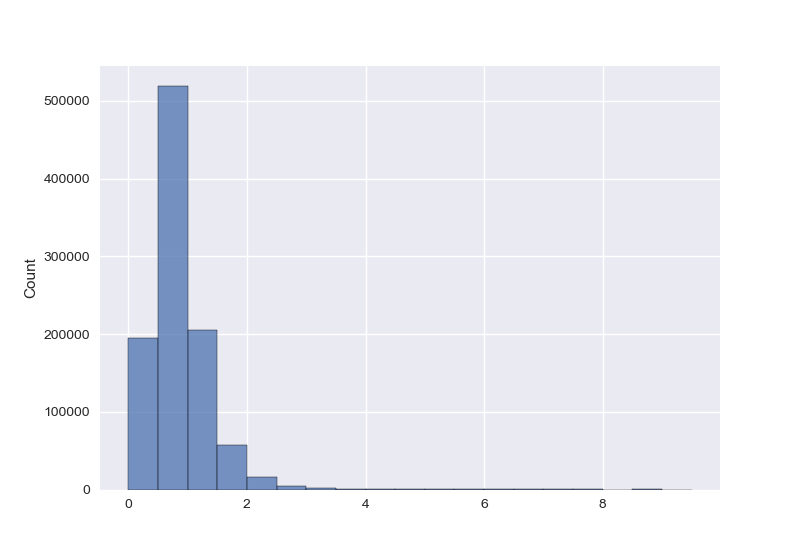

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


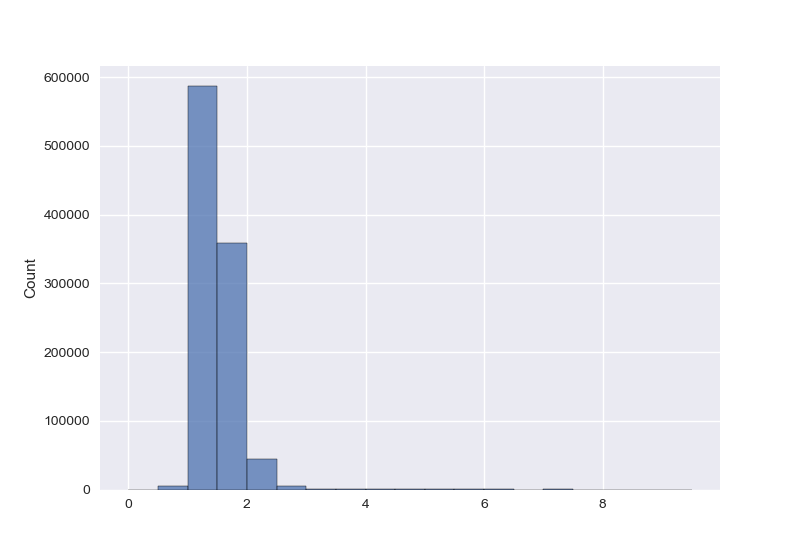

<IPython.core.display.Javascript object>

In [9]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


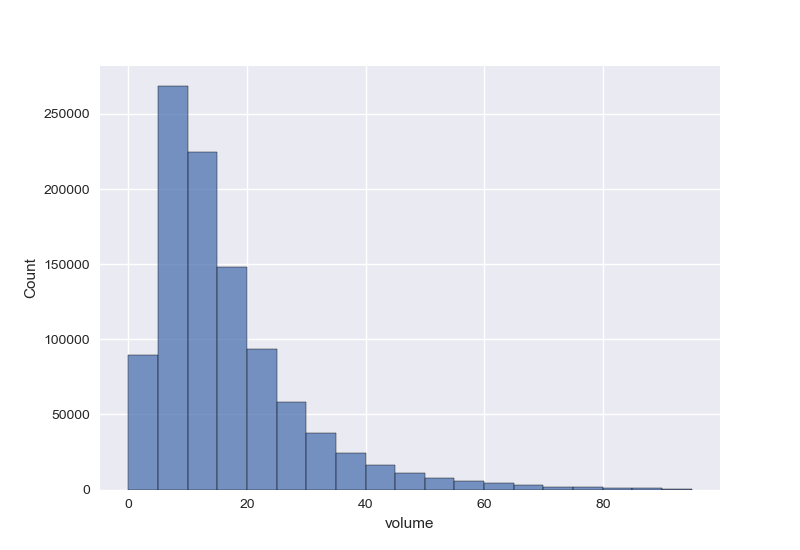

<IPython.core.display.Javascript object>

In [10]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


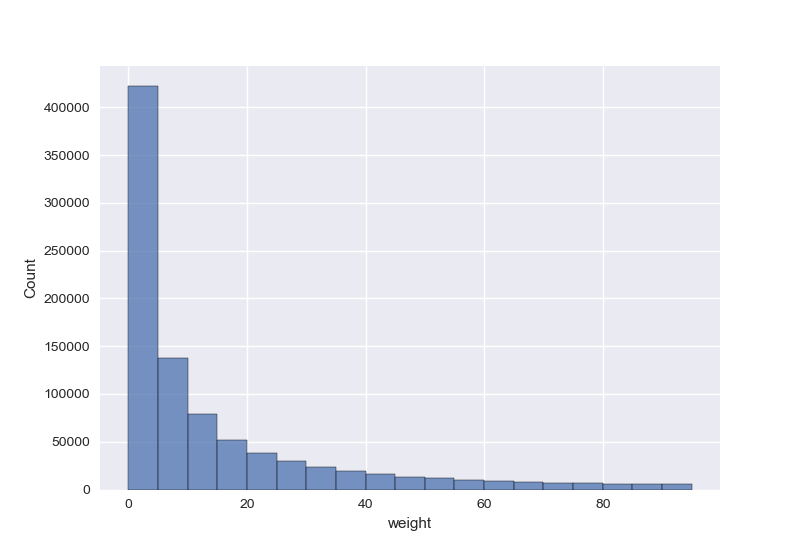

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


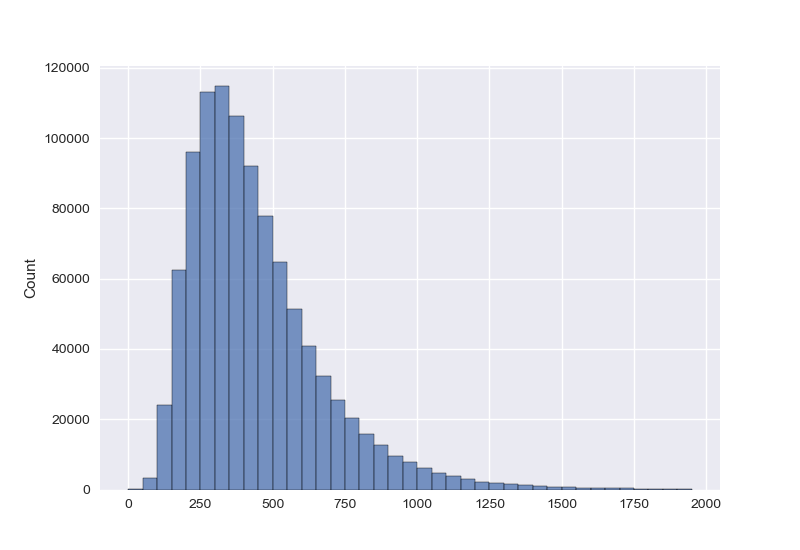

<IPython.core.display.Javascript object>

In [12]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [6]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [68]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [69]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


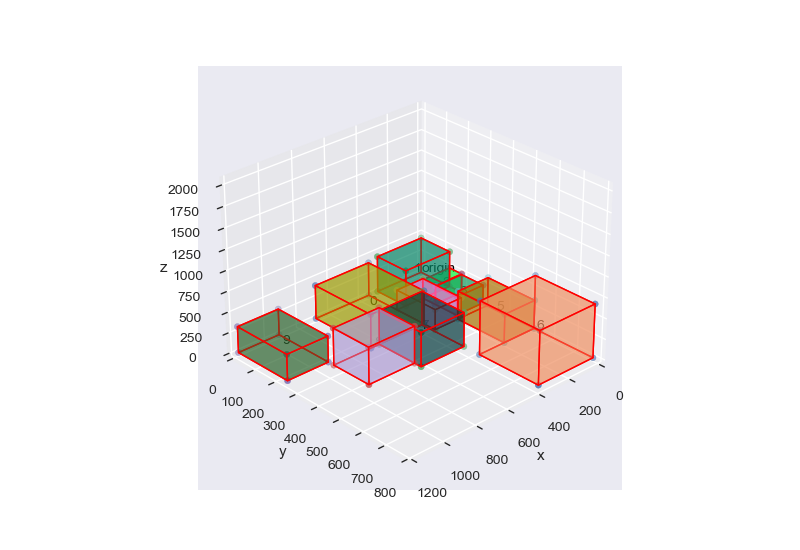

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [16]:
order = pd.read_csv("test_order.csv", index_col="Unnamed: 0")
order

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340
5,644167,286,158,481,6,21735428
6,110268,318,267,483,40,41009598
7,732180,245,379,394,25,36584870
8,54886,249,142,388,3,13718904
9,137337,143,343,297,2,14567553


<IPython.core.display.Javascript object>

In [7]:
mr_layer_pool = main.main(order, procedure="mr")
mr_layer_pool.to_dataframe()

2021-08-07 11:56:56.592 | INFO     | main:main:159 - Starting Baseline procedure
2021-08-07 11:56:56.593 | INFO     | main:main:169 - Baseline iteration 1/1
2021-08-07 11:56:56.594 | INFO     | superitems:gen_superitems:551 - Generating Superitems
2021-08-07 11:56:56.602 | DEBUG    | superitems:_gen_single_items_superitems:577 - Generated 50 SingleItemSuperitems
2021-08-07 11:56:56.603 | DEBUG    | superitems:_gen_superitems_vertical:677 - Generated 34 Wide VerticalSuperitems
2021-08-07 11:56:56.604 | DEBUG    | superitems:_gen_superitems_vertical:679 - Generated 14 Deep VerticalSuperitems
2021-08-07 11:56:56.605 | INFO     | superitems:gen_superitems:568 - Generated 98 Superitems
2021-08-07 11:56:56.606 | INFO     | main:maxrects_warm_start:43 - Computing MR layers
2021-08-07 11:56:56.637 | DEBUG    | main:maxrects_warm_start:51 - No height groups found, fallback to standard procedure
2021-08-07 11:56:56.638 | INFO     | main:maxrects_warm_start:58 - Processing height group 1/1
2021-0

,item,x,y,z,width,depth,height,layer
0,0,0,0,0,193,221,371,0
1,1,193,0,0,236,142,437,0
2,2,429,0,0,228,139,254,0
3,3,657,0,0,267,131,322,0
4,4,924,0,0,253,191,580,0
5,5,429,139,0,286,158,481,0
6,6,715,191,0,318,267,483,0
7,7,0,221,0,245,379,394,0
8,8,245,297,0,249,142,388,0
9,9,1033,191,0,143,343,297,0


<IPython.core.display.Javascript object>

2021-08-07 11:57:00.304 | DEBUG    | maxrects:maxrects_single_layer_online:139 - Starting MR-SL-Online
2021-08-07 11:57:00.304 | DEBUG    | maxrects:maxrects_single_layer_online:149 - MR-SL-Online: Non-zero duals to place 12
2021-08-07 11:57:00.309 | DEBUG    | maxrects:maxrects_single_layer_online:195 - MR-SL-Online: Generated new Layer with 12 Superitems, of which 12 with Dual > 0,with 3D-density 0.5071194045174539


<IPython.core.display.Javascript object>


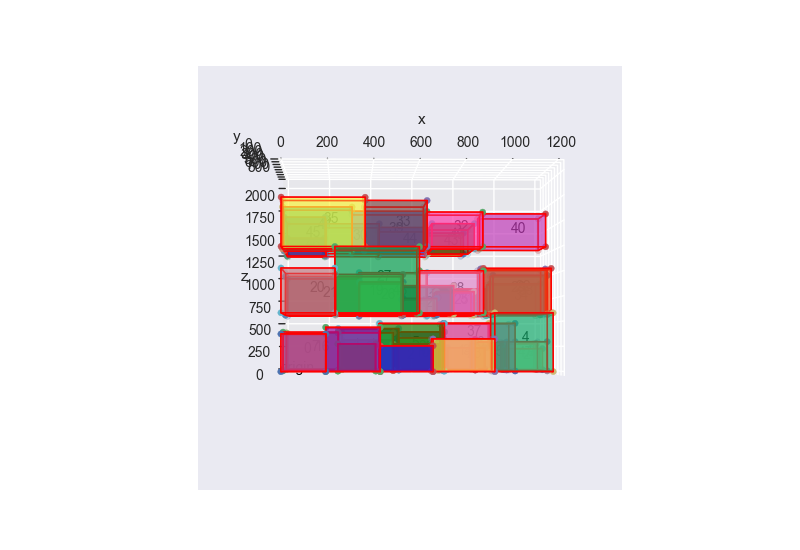

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [8]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

<IPython.core.display.Javascript object>


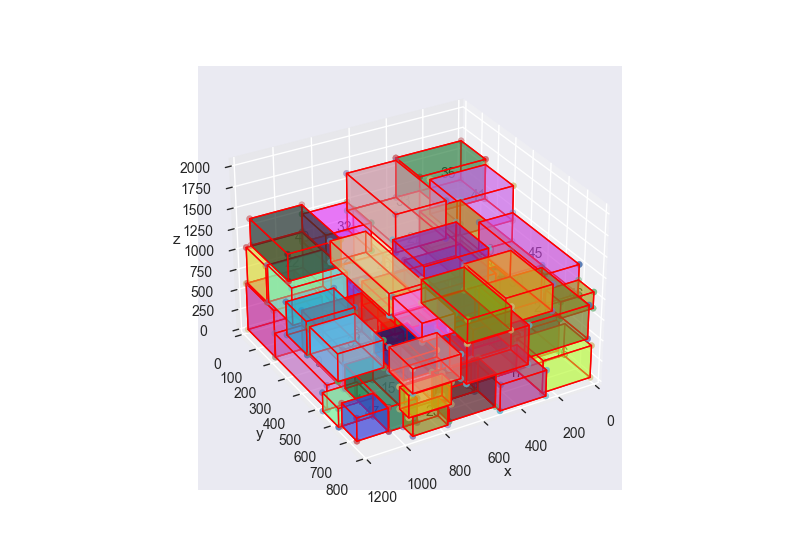

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [83]:
mr_compact_bin_pool = bins.CompactBinPool(mr_bin_pool)
mr_compact_bin_pool.plot()

## Column generation

In [ ]:
cg_layer_pool, cg_bins_lbs = main.main(order, procedure="cg", use_height_groups=False, tlim=5)
cg_layer_pool.to_dataframe()

2021-07-31 17:27:01.159 | INFO     | main:main:159 - Starting Baseline procedure
2021-07-31 17:27:01.160 | INFO     | main:main:169 - Baseline iteration 1/1
2021-07-31 17:27:01.161 | INFO     | superitems:gen_superitems:551 - Generating Superitems
2021-07-31 17:27:01.169 | DEBUG    | superitems:_gen_single_items_superitems:577 - Generated 50 SingleItemSuperitems
2021-07-31 17:27:01.171 | DEBUG    | superitems:_gen_superitems_vertical:677 - Generated 34 Wide VerticalSuperitems
2021-07-31 17:27:01.172 | DEBUG    | superitems:_gen_superitems_vertical:679 - Generated 14 Deep VerticalSuperitems
2021-07-31 17:27:01.173 | INFO     | superitems:gen_superitems:568 - Generated 98 Superitems
2021-07-31 17:27:01.175 | INFO     | main:cg:107 - Processing height group 1/1
2021-07-31 17:27:01.176 | INFO     | main:maxrects_warm_start:43 - Computing MR layers
2021-07-31 17:27:01.213 | DEBUG    | main:maxrects_warm_start:51 - No height groups found, fallback to standard procedure
2021-07-31 17:27:01.21

2021-07-31 17:27:06.650 | INFO     | column_generation:pricing_problem_no_placement_mip:249 - SP-NP-MIP solved
2021-07-31 17:27:06.651 | DEBUG    | column_generation:pricing_problem_no_placement_mip:252 - SP-NP-MIP objective: -5733.000000000001
2021-07-31 17:27:06.652 | DEBUG    | column_generation:pricing_problem_no_placement_mip:255 - SP-NP-MIP selected 15/98 superitems
2021-07-31 17:27:06.653 | DEBUG    | column_generation:pricing_problem_no_placement_mip:257 - SP-NP-MIP computed layer height: -0.0
2021-07-31 17:27:06.653 | DEBUG    | column_generation:pricing_problem_no_placement_mip:261 - SP-NP-MIP time: 0.018
2021-07-31 17:27:06.662 | INFO     | column_generation:pricing_problem_placement_cp:362 - SP-P-CP defining variables and constraints
2021-07-31 17:27:11.679 | WARNING  | column_generation:pricing_problem_placement_cp:445 - SP-P-CP unfeasible
2021-07-31 17:27:11.680 | DEBUG    | column_generation:pricing_problem_placement_cp:447 - SP-P-CP time: 5.011649881
2021-07-31 17:27:11

2021-07-31 17:27:16.882 | DEBUG    | column_generation:pricing_problem_no_placement_mip:261 - SP-NP-MIP time: 0.02
2021-07-31 17:27:16.891 | INFO     | column_generation:pricing_problem_placement_cp:362 - SP-P-CP defining variables and constraints
2021-07-31 17:27:21.907 | WARNING  | column_generation:pricing_problem_placement_cp:445 - SP-P-CP unfeasible
2021-07-31 17:27:21.908 | DEBUG    | column_generation:pricing_problem_placement_cp:447 - SP-P-CP time: 5.010855403
2021-07-31 17:27:21.909 | INFO     | column_generation:pricing_problem_no_placement_mip:180 - SP-NP-MIP defining variables and constraints
2021-07-31 17:27:21.917 | INFO     | column_generation:pricing_problem_no_placement_mip:217 - SP-NP-MIP feasibility: max number of selected items <= 16
2021-07-31 17:27:21.918 | DEBUG    | column_generation:pricing_problem_no_placement_mip:225 - SP-NP-MIP zero duals reward: 0.0015772870662460567
2021-07-31 17:27:21.919 | DEBUG    | column_generation:pricing_problem_no_placement_mip:240

<IPython.core.display.Javascript object>


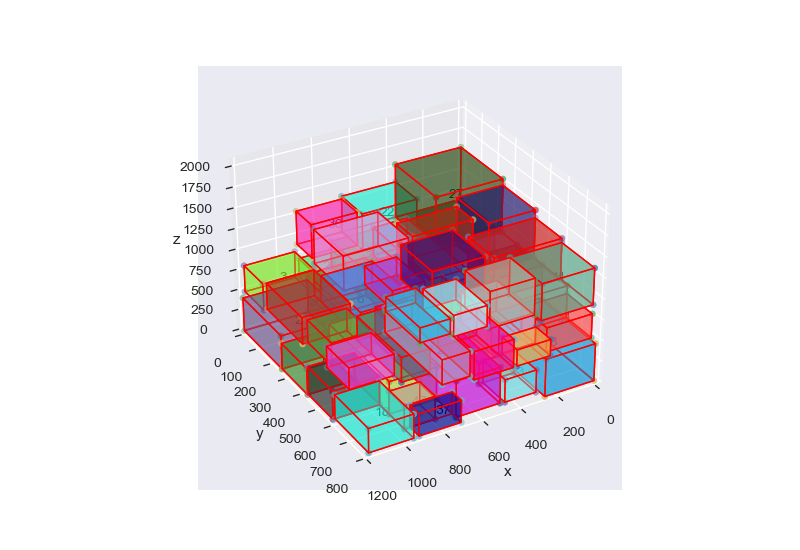

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [54]:
cg_bin_pool = bins.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

## Comparison

In [55]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1543]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.7665031465665977, 0.7084644678776683, 0.4206487241972477]]

	MR
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.5825106731014271, 0.5504133117816092, 0.48390885308385306]


<IPython.core.display.Javascript object>